In [3]:
%load_ext autoreload
%autoreload 2

import optax
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

from simple_pendulum import get_simple_pendulum_sequence, get_cos_sin_states
from training import fit
from polynomial_model import predict, get_zs
from constants import RAND_KEY

### Simple Pendulum states

In [4]:
dt = 0.01
start_state = jnp.array([jnp.pi / 4, 0.])
V0 = jnp.eye(2) * 0.00001
trans_noise = jnp.eye(2) * 0.00001
obs_noise = jnp.eye(2) * 0.001

num_steps = 2000
N = 100

zs, xs = get_simple_pendulum_sequence(start_state, V0, trans_noise, obs_noise, num_steps, N, dt)
cos_sin_zs = get_cos_sin_states(zs)

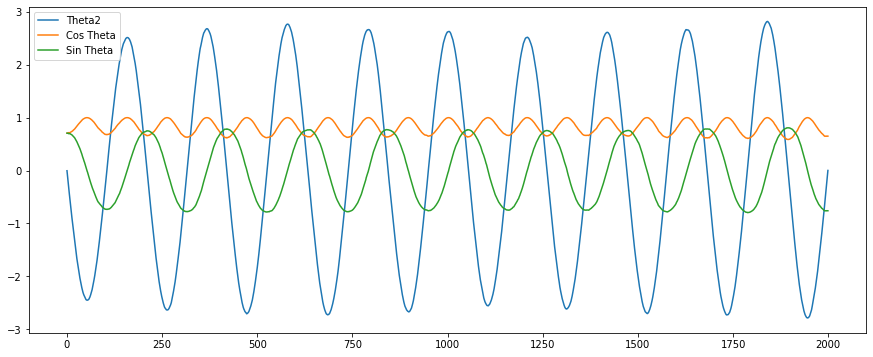

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(zs[:, 0, 1], label="Theta2")
plt.plot(cos_sin_zs[:, 0, 0], label="Cos Theta")
plt.plot(cos_sin_zs[:, 0, 1], label="Sin Theta")
plt.legend()
plt.show()

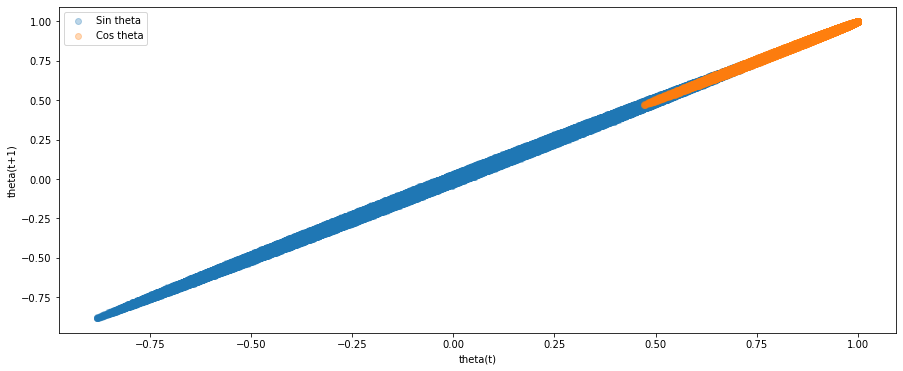

In [10]:
plt.figure(figsize=(15, 6))
plt.scatter(cos_sin_zs[:-1, :, 1], cos_sin_zs[1:, :, 1], label="Sin theta")
plt.scatter(cos_sin_zs[:-1, :, 0], cos_sin_zs[1:, :, 0], label="Cos theta")
plt.xlabel('theta(t)')
plt.ylabel('theta(t+1)')
plt.legend()
plt.show()

### Learn Simple pendulum dynamics

In [11]:
dt = 0.01
V0 = jnp.eye(2) * 0.0001
trans_noise = jnp.eye(2) * 0.001
obs_noise = jnp.eye(2) * 0.1

num_steps = 10
N = 10000
NUM_TRAINING_STEPS = 4000
LR_ESTIMATOR = False

start_state = jnp.array([jnp.pi / 4, 0.])
zs, xs = get_simple_pendulum_sequence(start_state, V0, trans_noise, obs_noise, num_steps, N, dt)

start_state = jnp.array([jnp.cos(start_state[0]), jnp.sin(start_state[0])])
cos_sin_zs = get_cos_sin_states(zs)
cos_sin_xs = get_cos_sin_states(xs)

num_features = 4

start_weights = jnp.zeros((num_features,))
params = jnp.array([start_weights])


optimizer = optax.chain(
    optax.adam(learning_rate=0.001),
    optax.scale(-1.0)
)

optimizer.init(params)

learned_params, training_objectives, gradients = fit(
    params=params,
    optimizer=optimizer,
    training_steps=NUM_TRAINING_STEPS,
    num_features=num_features,
    start_state=start_state,
    V0=V0, 
    trans_noise=trans_noise,
    obs_noise=obs_noise,
    xs=cos_sin_zs,
    num_steps=num_steps,
    N=N,
    lr_estimator=LR_ESTIMATOR,
)

Step 0, ELBO: -4447.47998046875, grads: [12693.98    8995.415   6400.7446  4572.744 ], A - [0.00099999 0.00099999 0.00099999 0.00099999]
Step 100, ELBO: -1920.1683349609375, grads: [8400.199 5951.954 4234.566 3024.754], A - [0.09396555 0.09396352 0.09396128 0.09395885]
Step 200, ELBO: -667.5279541015625, grads: [5065.837  3588.53   2552.4062 1822.6542], A - [0.16607644 0.16606495 0.16605216 0.16603816]
Step 300, ELBO: -162.024169921875, grads: [2745.1997  1943.6399  1381.66     986.01965], A - [0.21622153 0.21618955 0.21615411 0.21611543]
Step 400, ELBO: -0.7430641651153564, grads: [1322.1112   934.94574  663.7286   472.9759 ], A - [0.24695428 0.24688907 0.24681683 0.24673803]
Step 500, ELBO: 39.04238510131836, grads: [563.256   397.06876 280.9022  199.405  ], A - [0.2633508  0.2632402  0.26311755 0.26298383]
Step 600, ELBO: 46.56756591796875, grads: [212.60423 148.5328  104.01361  73.00183], A - [0.27095672 0.27079    0.27060556 0.27040398]
Step 700, ELBO: 47.65734100341797, grads: [7

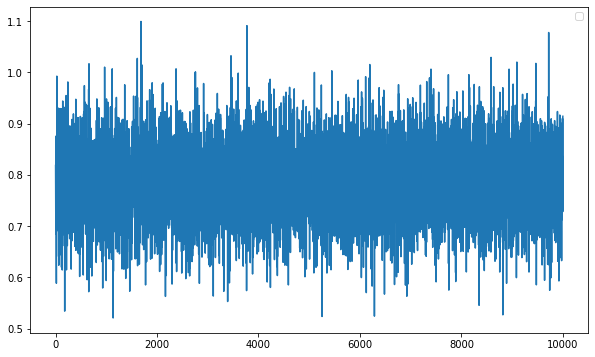

In [19]:
epsilons = jrandom.normal(key=RAND_KEY, shape=(num_steps, N, 2))
pred_zs = get_zs(learned_params[0], start_state, V0, trans_noise, epsilons)
pred_angles = jnp.arctan2(pred_zs[:, :, 0], pred_zs[:, :, 1])

plt.figure(figsize=(10, 6))
# plt.scatter(pred_zs[:-1, :, 1], pred_zs[1:, :, 1], label="State sequence prediction")
# plt.scatter(cos_sin_zs[:-1, :, 1], cos_sin_zs[1:, :, 1], label="Ground truth")
plt.plot(pred_angles.mean(axis=0))
plt.legend()
plt.show()